### Walmart Sales Forecasting - Using Auto ARIMA

In [21]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

#### Data Preprocessing

In [22]:
# importing the dataset

df = pd.read_csv('Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [23]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [24]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst = True)
df = df.drop_duplicates(subset='Date', keep='first')
df.set_index('Date',inplace= True)
df = df.resample('W-FRI').sum()
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


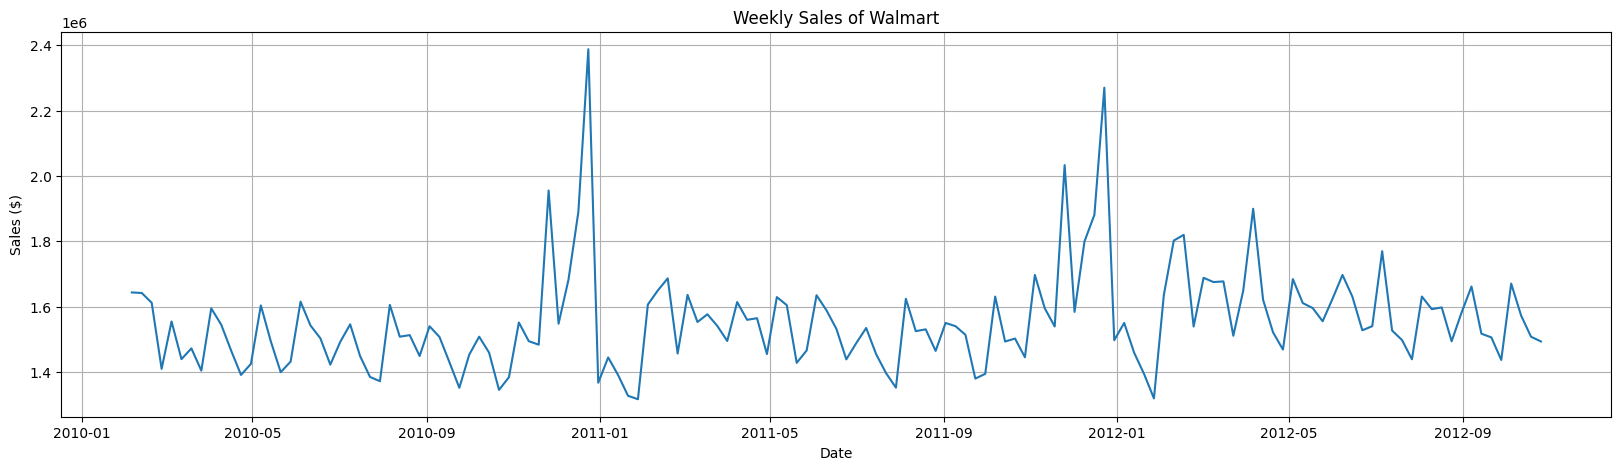

In [25]:
# plotting Weekly sales

plt.figure(figsize=(20,5))
plt.plot(df['Weekly_Sales'], label = 'Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.title('Weekly Sales of Walmart')
plt.grid()
plt.show()

#### Seasonality test

<Figure size 2000x500 with 0 Axes>

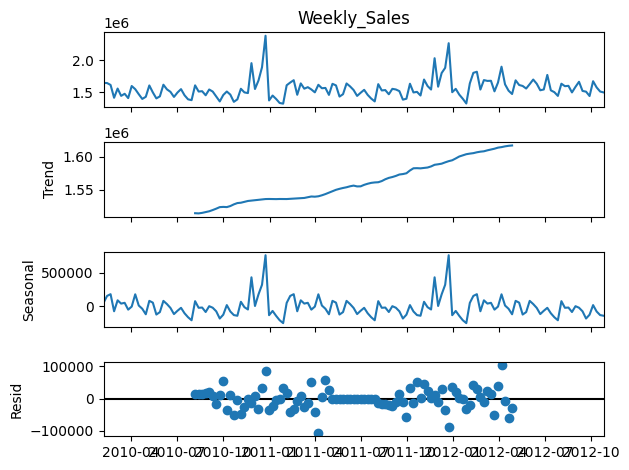

In [26]:
# seasonality check

from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(20,5))
snl = seasonal_decompose(df['Weekly_Sales'])
snl.plot()
plt.show()

#### Stationarity test

In [27]:
# stationarity check

from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print('Dickey Fuller test results')
    adf = adfuller(timeseries,autolag ='AIC')
    adf_output = pd.Series(adf[0:4],index = ['Test Statistics','p-value','No of lags','No of Observations'])
    for key,value in adf[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print(adf_output)

In [28]:
adf_test(df['Weekly_Sales'])

Dickey Fuller test results
Test Statistics          -5.102186
p-value                   0.000014
No of lags                4.000000
No of Observations      138.000000
Critical Value (1%)      -3.478648
Critical Value (5%)      -2.882722
Critical Value (10%)     -2.578065
dtype: float64


p < 0.05 . Therefore, the time series is stationary.

In [29]:
# if p > 0.05, differencing is required. In that case use the following code for differencing.

#df['Sales_Diff'] = df['Weekly_Sales'].diff().dropna()
#result_diff = adfuller(df['Sales_Diff'].dropna())
#print(f"ADF after differencing: {result_diff[1]}")

In [30]:
# Calculate min and max
min_val = df['Weekly_Sales'].min()
max_val = df['Weekly_Sales'].max()

# Apply Min-Max scaling
df['Weekly_Sales'] = (df['Weekly_Sales'] - min_val) / (max_val - min_val)
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,0.305113,0,42.31,2.572,211.096358,8.106
2010-02-12,1,0.303495,1,38.51,2.548,211.242170,8.106
2010-02-19,1,0.275495,0,39.93,2.514,211.289143,8.106
2010-02-26,1,0.086670,0,46.63,2.561,211.319643,8.106
2010-03-05,1,0.222125,0,46.50,2.625,211.350143,8.106


In [31]:
# splitting training and test data

train_size = int(len(df)*0.8)
test_size = len(df) - train_size

df_train = df[:train_size]
df_test = df[train_size:]

#### Identifying SARIMA Orders [p,d,q][P,D,Q,s]

In [32]:
model = auto_arima(
    df_train['Weekly_Sales'],
    seasonal= True,
    m = 52, # weekly data, yearly seasonality
    stepwise= True,
    trace= True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.36 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-58.365, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-60.350, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=-158.710, Time=2.30 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=-156.710, Time=12.09 sec
 ARIMA(0,1,0)(1,0,2)[52] intercept   : AIC=inf, Time=15.77 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=inf, Time=16.00 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=inf, Time=9.24 sec
 ARIMA(0,1,0)(2,0,2)[52] intercept   : AIC=inf, Time=14.51 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=-173.104, Time=2.72 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=1.61 sec


Best model : SARIMA(0,1,2)(1,0,0,52)

#### Training SARIMA model

In [41]:
model = SARIMAX(
    df_train['Weekly_Sales'],
    order = (0,1,2),
    seasonal_order= (1,0,0,52),
    enforce_stationarity= False
)

results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 52)   Log Likelihood                  84.741
Date:                             Sat, 31 May 2025   AIC                           -161.481
Time:                                     09:51:05   BIC                           -153.038
Sample:                                 02-05-2010   HQIC                          -158.172
                                      - 04-06-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7921      0.143     -5.525      0.000      -1.073      -0.511
ma.L2         -0.0318      

#### Model Validation

In [42]:
# Forecast on test data
forecast_test = results.get_forecast(steps=test_size)
forecast_mean_test = forecast_test.predicted_mean
conf_int_test = forecast_test.conf_int()


In [43]:
# Calculate metrics

from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(df_test['Weekly_Sales'], forecast_mean_test)
rmse = mean_squared_error(df_test['Weekly_Sales'], forecast_mean_test, squared=False)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 0.07
RMSE: 0.08


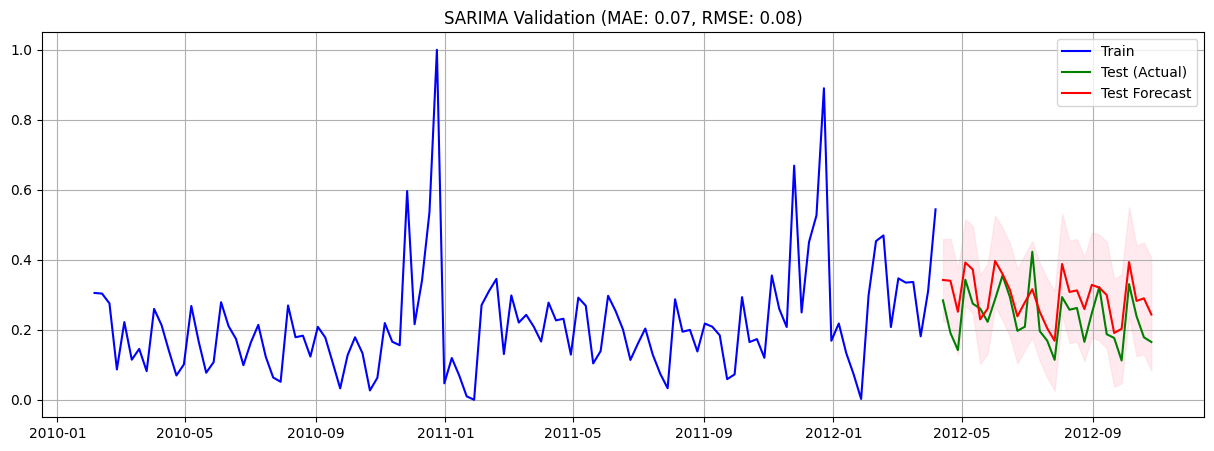

In [44]:
# Plot validation
plt.figure(figsize=(15, 5))
plt.plot(df_train.index, df_train['Weekly_Sales'], label='Train', color='blue')
plt.plot(df_test.index, df_test['Weekly_Sales'], label='Test (Actual)', color='green')
plt.plot(forecast_mean_test.index, forecast_mean_test, label='Test Forecast', color='red')
plt.fill_between(conf_int_test.index, conf_int_test.iloc[:, 0], conf_int_test.iloc[:, 1], color='pink', alpha=0.3)
plt.title(f"SARIMA Validation (MAE: {mae:.2f}, RMSE: {rmse:.2f})")
plt.legend()
plt.grid()
plt.show()

#### Forecast

In [49]:
model = SARIMAX(
    df['Weekly_Sales'],
    order = (0,1,2),
    seasonal_order= (1,0,0,52),
    enforce_stationarity= False
)

results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 52)   Log Likelihood                 127.282
Date:                             Sat, 31 May 2025   AIC                           -246.564
Time:                                     09:51:41   BIC                           -236.565
Sample:                                 02-05-2010   HQIC                          -242.532
                                      - 10-26-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8680      0.115     -7.560      0.000      -1.093      -0.643
ma.L2         -0.0409      

In [50]:
# forecasting next 12 weeks

forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
fitted_values = results.fittedvalues # predictions for historical data

In [51]:
forecast_mean

2012-11-02    0.387773
2012-11-09    0.305741
2012-11-16    0.260851
2012-11-23    0.660597
2012-11-30    0.296954
2012-12-07    0.471474
2012-12-14    0.537441
2012-12-21    0.852335
2012-12-28    0.226837
2013-01-04    0.269663
2013-01-11    0.196189
2013-01-18    0.143406
Freq: W-FRI, Name: predicted_mean, dtype: float64

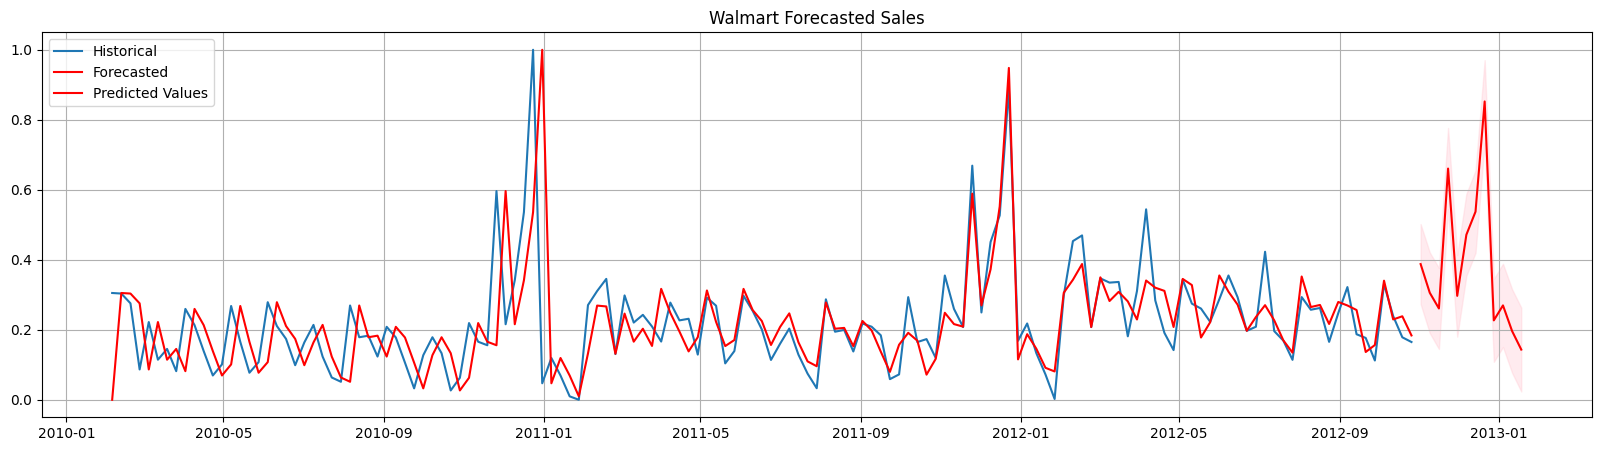

In [52]:
# plot

plt.figure(figsize=(20,5))
plt.plot(df['Weekly_Sales'], label = 'Historical')
plt.plot(forecast_mean.index , forecast_mean,label = 'Forecasted', color = 'red')
plt.plot(fitted_values.index, fitted_values, label = 'Predicted Values', color = 'red')
plt.fill_between(
    confidence_intervals.index,
    confidence_intervals.iloc[:,0],
    confidence_intervals.iloc[:,1],
    color = 'pink',
    alpha = 0.3
)

plt.title('Walmart Forecasted Sales')
plt.legend()
plt.grid()
plt.show()